In [9]:
#This is the flat field dictionary creator.
#it must be run before the pipeline is run since we need the flatDict var
#do not run create_flat_dict_file unless you have added a new flat field to the flats folder
import pickle
import pprint
from pipeline import create_flat_dict_file

#computer specific directories
homePath = 'D:/My Documents/Coding Projects/nreshk/'
dataPath =homePath + 'data/'
outputPath = homePath + 'output/'
flatPath = dataPath + 'flats/'
flatPickle = "flatDict.pkl"

#UNCOMMENT TO RECREATE THE FLAT DICTIONARY
create_flat_dict_file(flatPath,flatPickle)

f = open(flatPath+flatPickle,"rb")
flatDict = pickle.load(f)
f.close()


#pprint.pprint(flatDict)

In [8]:
#loading the reference spectra is a long process so we don't want to do it much
%load_ext autoreload
%autoreload 2

from calc_del_lambda import import_lab_frame_spectra

#need this in memory for the following wrapper
lab = import_lab_frame_spectra(dataPath+ 'LabSpectra/', resolution=0)#,res*10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


HD 100180 already has output
HD 114710 already has output
HD 115383 already has output
HD 115404 already has output
HD 120136 already has output
HD 12235 already has output
HD 126053 already has output
HD 136202 already has output
HD 149661 already has output
HD 152391 already has output
HD 154417 already has output
HD 165341A already has output
HD 17051 already has output
HD 176051 already has output
HD 182101 already has output
HD 1835 already has output
HD 187691 already has output
HD 190406 already has output
HD 194012 already has output
HD 20630 already has output
HD 206860 already has output
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 22049
-------------------------------------------------------------------------------
loading 20180731
bad flat detected mk_flatolap.py
MJD: 58331.342243 and decYr 2018.581759569863 w/ shk: 0.654794795063853 and offset:0.0708449564730818
bad correlation: 1.1221734648130306
bad: 58331.342243
-

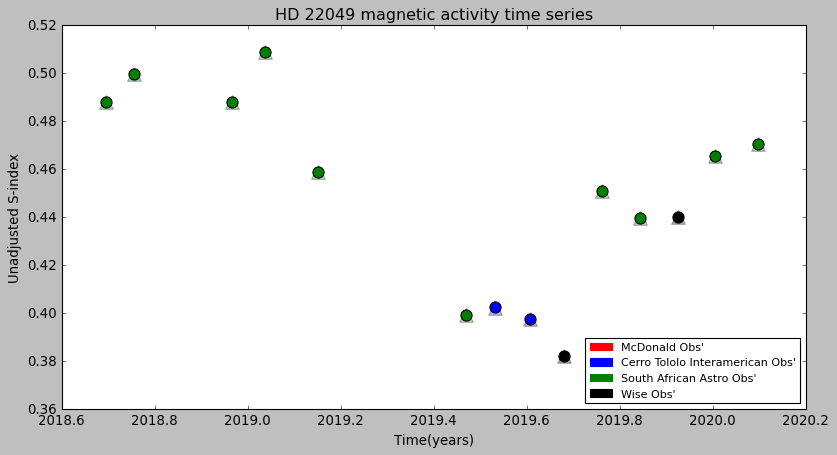

HD 26913 already has output
HD 30495 already has output
HD 37394 already has output
HD 43587 already has output
HD 49933 already has output
HD 75332 already has output
HD 76151 already has output
HD 78366 already has output
HD 82443 already has output
HD 82885 already has output
HD 88737 already has output
HD 98230B already has output
bad folder 'flats'
bad folder 'LabSpectra'


In [13]:
#this is the BIG wrapper. This handles all the folder structure stuff and manages the
#pipeline. The general outline of pipeline is(search tag to find general location);
#
#TAG_0_ import data to arrays
#TAG_1_ create flat field
#TAG_2_ remove instrumental error by dividing out flat field
#TAG_3_ align stellar spectrum to reference by cross correlation
#TAG_4_ find ca HK emission reversal and calculate s-index(shk)
#TAG_5_ detect bad spectra and erronous data and remove from final product
#TAG_6_ Sum spectra from each night(2-3 obs per night) to increase signal/noise
#TAG_7_ Calculate S-index for each nights combined data
#TAG_8_ print intermediate pdfs(for single and combined obs) for debugging into output folder
#TAG_9_ plot final time series of star with all good data included
#
#loop through each star as desired
import scipy.constants as sc

import astropy.io.fits
import numpy as np
import os
import helpers as h
import logging

from calc_shk import calc_targOlapf
from calc_shk import calc_shk
from calc_shk import smart_calc_shk


import pipeline as pipe

from calc_del_lambda import calc_del_lam


from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt

from astropy.time import Time
#from matplotlib.backends.backend_pdf import PdfPages


setName = ''

#resolution for printing
res = .01
label =''



#todo fill this to print out in 
bad = []#[58330.3596906,58330.3634695,
      # 58553.7527935,58553.7479017,
      # 58272.4211262,58272.4248934,
      # 58354.2323109,58354.2381758]

#a list of stars we MUST run, regardless of if there is already output
forceRun = ["22049"]#["76151","22049"]
    
    
    
stars = h.get_immediate_subdirectories(dataPath)
    
#loop through every folder in the data files path. 
#these folders hold all the data for each star
for s in stars:
    if not h.is_folder_star(s):
        print('bad folder \'' + s + '\'')
        continue
    #if the star has an output folder and isnt forced to run we won't run again
    if os.path.exists(outputPath+s+'/') and s not in forceRun:
        print("HD " + s + " already has output")
        continue
    
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Running pipeline on HD " + s)
    setName = s
    #need blank arrays to append to since we don't know length due to bad spectra
    data = [[],[],[],[]]
    tryData =[]
    dailyData = dict()

    #we're going to loop through all folders in a stars data and determine if each is 
    #old or new format once thats determined we get the wave/flat/spec data differently
    #then we should not care about the format anymore and will do the pipeline as normal
    for path, subdirs, files in os.walk(dataPath + setName):
        #walk through each folder this is the main loop over all observations
        #each dir here should only contain one observation
        #print(subdirs)


        for dirs in subdirs:
            if dirs == 'flats':
                continue

            print('-------------------------------------------------------------------------------')
            curFiles = os.listdir(os.path.join(path,dirs))
            print('loading ' + dirs)
            #print('current files')
            #print(curFiles)

            #TAG_0_
            #TODO CLOSE FITS FILES (&*$)@&*$)@&*#$)@#$
            folderRet = pipe.load_folder_for_pipeline(path, dirs, curFiles)

            waveGrid = folderRet[0]#key for pipeline
            spec = folderRet[1]#key for pipeline
            header = folderRet[2]
            obsFileName = folderRet[3]
            old = folderRet[4]#is old format or not, for debugging
           
            #if you have data from a different system you may just want to simulate the header
            #dictionary.
            mjd = header['MJD-OBS']
            site = header['SITEID']


            decimalYr = Time(mjd,format='mjd')
            decimalYr.format = 'decimalyear'
            label=str(mjd).replace('.','/') 

            tempEff = h.tEffLookup[setName.strip('/')]

            #title for pdfs
            title = ''
            #BEGIN FORMAT INDEPENDANT CODE(HOPEFULLY)



            #try to find a flat otherwise fail
            #try:
            fD = flatDict[site]
            #flatDates = list(flatDict.keys())
            #flatDates.sort(key=lambda x: abs(x - mjd))
            fK = h.closestKey(fD,float(mjd))

            flatFilePath = fD[fK]
            
            fHDu = astropy.io.fits.open(os.path.join(path,flatFilePath))

            flat = fHDu[0].data#key for pipeline

            #if abs(mjd-fK) > 25:
            #    print('BAD BAD closest for: '+str(mjd) +' is '+ str(abs(mjd-fK)))
            #elif abs(mjd-fK) > 2:
            #    print('closest for: '+str(mjd) +' is '+ str(abs(mjd-fK)))
            
            #TAG_1_
            #give multiple arrays of flats whose lam values are stored in multiple wave grid arrays
            flatRet = mk_flatolap(waveGrid, flat)

            #except:
               # print('bad flat find with site: ' + site + ' and date ' + str(obsDate))
                #continue


            #return one flat array with lambda grid
            flatOlap = flatRet[1]
            lamGrid = flatRet[0]

            #TAG_2_
            #get the target data minus the flat
            targOlapf = calc_targOlapf(lamGrid, waveGrid, spec, flatOlap, label)

            #TAG_3_
            #cross correlation returns a lambda offset(dlam) and save the lab spectra
            correlation = calc_del_lam(lab[0]/10,lab[1], lamGrid, targOlapf,res)
            dLam = correlation[0]
            labSpec = correlation[2]


            #radial velocity calculation
            #lamRef = 396.85
            #delta lamda / ref lamda * speed of light
           # rv = dLam/ lamRef * sc.c 
            #rv from meters to km/s as desired by hk_windows
            #atm we're not going to apply the radial velocity and just use the adjusted spectra
            rv = 0#rv/10000 


            
            #TAG_4_
            #find SHK with new offset to lamda grid
            shkRet = calc_shk(lamGrid-dLam, targOlapf, rv, teff=tempEff)
            shk = shkRet[0]
            windows = shkRet[1]
            
            #if old:
             #   shk=shk*2
            print('MJD: ' + str(mjd) + ' and decYr ' + str(decimalYr) + ' w/ shk: ' + str(shk) + ' and offset:' + str(dLam))

            #TAG_5_
            #time to toss bad spec so they won't be summed
            badSpec = False
            #not included but may need to be, check if any values of targolapf
            #are negative. Makes sense to me that those spectra should be tossed
            badSpec = h.bad_spec_detection_v2(lamGrid-dLam,targOlapf)          
            
            #among other things?!
            if shk < 0 or shk > 1 or flatRet[2] == True:
                badSpec = True          

            if badSpec:
                bad.append(mjd)
                title +='BAD '

            #create the directories for pdf plotting and save every intermediate data array
            first = label.split("/")[0]
            second = label.split("/")[1]
            h.mkdir_p("output/"+setName+"/"+first+'/')
            
            np.savez("output/"+setName+"/"+first+"/"+ second+"_data", targOlapf=targOlapf,flatOlap=flatOlap, lamGrid=lamGrid, adjLamGrid=lamGrid-dLam,windows=windows)

            title += 'NRES spectra, ' + site +', '+header['DATE-OBS']+' ('+ '{:.6}'.format(decimalYr.value) +'), S='+'{:.4}'.format(shk)
            h.pdf_from_data(lamGrid, labSpec,lamGrid-dLam, targOlapf, windows,title, "output/"+setName+"/"+first+"/",second,flatOlap,.3)

            if(badSpec):
                print('bad: ' + str(mjd))
                continue

            tryData.append(h.data(mjd,header,lamGrid,targOlapf,correlation[0],shk,False))
            #OUTPUT FOR FURTHER PRINTING
            data[0].append(mjd)
            data[1].append(shk)
            data[2].append(tuple((header,False)))
            data[3].append(tuple((lamGrid,correlation[0],targOlapf)))
        #end of star's loop 
        
    #major portions of the pipeline are kept in these two functions for readability.
    #We could likely functionize from individual observation folder-> data output as well
    #but if people are interested in putting data through this pipeline from other telescopes
    #many parts of the above code must be changed. The below would not need to be changed.
    #TAG_6_

    tryData = pipe.sum_daily_data(setName,tryData,labSpec)
    #data = pipe.sum_daily_data(setName,data,labSpec)
    #TAG_7_
    #TAG_8_
    #TAG_9_
    pipe.plot_daily_data_timeseries(tryData,setName,bad)
    #pipe.plot_daily_data_timeseries(data,setName,bad)